Maintain the same preprocessing as previous segmentation method


In [94]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer


from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score


from datetime import datetime



pd.set_option('display.max_columns', None)


In [95]:
path = 'customer_segmentation.csv'
df = pd.read_csv(path)

In [96]:
# Check unique categories and print if less than 10
print("\nUnique categories in non-numerical columns:")
non_numerical_cols = df.select_dtypes(exclude=['number']).columns
for col in non_numerical_cols:
    unique_categories = df[col].nunique()
    print(f"{col}: {unique_categories} unique categories")
    if unique_categories <= 10:
        print("Unique categories:")
        print(df[col].unique())


Unique categories in non-numerical columns:
Education: 5 unique categories
Unique categories:
['Graduation' 'PhD' 'Master' 'Basic' '2n Cycle']
Marital_Status: 8 unique categories
Unique categories:
['Single' 'Together' 'Married' 'Divorced' 'Widow' 'Alone' 'Absurd' 'YOLO']
Dt_Customer: 663 unique categories


In [97]:
mean_income = df['Income'].mean()
print("Mean Income: " + str(mean_income))
df['Income'].fillna(mean_income, inplace=True)

Mean Income: 52247.25135379061


C:\Users\nickd\AppData\Local\Temp\ipykernel_11812\1471172899.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Income'].fillna(mean_income, inplace=True)


In [98]:
to_drop = ['ID', 'AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'Complain', 'Z_CostContact', 'Z_Revenue', 'Response']
df.drop(columns=to_drop, inplace=True)
# df.head()




In [99]:
df.drop(columns='Dt_Customer', inplace=True)

In [100]:
numerical_cols = df.select_dtypes(include=['number']).columns


# Function to detect and handle outliers using IQR method

def handle_outliers(df, col):
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    
    # Detect outliers
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)][col]
    
    # Replace outliers with median
    median = df[col].median()
    df[col] = np.where((df[col] < lower_bound) | (df[col] > upper_bound), median, df[col])
    
    return outliers

# Detect and handle outliers for each numerical column
outliers_dict = {}
for col in numerical_cols:
    outliers = handle_outliers(df, col)
    outliers_dict[col] = outliers

# Print outliers for each numerical column
for col, outliers in outliers_dict.items():
    print(f"Outliers in {col}:")
    print(outliers)

# Print summary statistics after handling outliers
print("\nSummary statistics after handling outliers:")
print(df.describe())
print(df.shape)

Outliers in Year_Birth:
192    1900
239    1893
339    1899
Name: Year_Birth, dtype: int64
Outliers in Income:
164     157243.0
617     162397.0
655     153924.0
687     160803.0
1300    157733.0
1653    157146.0
2132    156924.0
2233    666666.0
Name: Income, dtype: float64
Outliers in Kidhome:
Series([], Name: Kidhome, dtype: int64)
Outliers in Teenhome:
Series([], Name: Teenhome, dtype: int64)
Outliers in Recency:
Series([], Name: Recency, dtype: int64)
Outliers in MntWines:
111     1332
161     1349
295     1241
424     1285
430     1248
466     1239
497     1396
515     1288
523     1379
543     1478
559     1492
824     1492
826     1279
870     1308
917     1478
937     1253
987     1394
990     1296
1001    1285
1010    1230
1052    1315
1191    1298
1458    1302
1488    1449
1492    1259
1577    1252
1641    1459
1749    1493
1922    1324
1953    1285
1961    1462
1992    1276
2067    1245
2098    1486
2127    1311
Name: MntWines, dtype: int64
Outliers in MntFruits:
0        8

In [101]:
df_operate  = df.copy()

In [102]:


marital_categories = df_operate["Marital_Status"].value_counts()
education_categories = df_operate["Education"].value_counts()

print(marital_categories)
print(education_categories)

marital_to_replace = {
    "Married": "Relationship",
    "Together":"Relationship",
    "Single": "Single",
    "Divorced": "Single",
    "Widow": "Single",
    "Alone": "Single",
    "YOLO": "Single"
}

df_operate["Marital_Status"] = df_operate["Marital_Status"].replace(marital_to_replace)
marital_categories = df_operate["Marital_Status"].value_counts()
print(marital_categories)



education_to_replace = {
    "Graduation": "Graduation",
    "PhD": "PhD",
    "Master" :"Master",
    "2n Cycle": "Foundational",
    "Basic": "Foundational"
}

df_operate["Education"] = df_operate["Education"].replace(education_to_replace)
education_categories = df_operate["Education"].value_counts()
print(education_categories)


Marital_Status
Married     864
Together    580
Single      480
Divorced    232
Widow        77
Alone         3
Absurd        2
YOLO          2
Name: count, dtype: int64
Education
Graduation    1127
PhD            486
Master         370
2n Cycle       203
Basic           54
Name: count, dtype: int64
Marital_Status
Relationship    1444
Single           794
Absurd             2
Name: count, dtype: int64
Education
Graduation      1127
PhD              486
Master           370
Foundational     257
Name: count, dtype: int64


In [103]:
#code to infer the age of the persons

current_year = datetime.now().year

df_operate['age'] = current_year - df_operate['Year_Birth']


In [104]:
# One-hot encode non-numeric columns (excluding date-related columns)
categorical_columns = df_operate.select_dtypes(include=['object']).columns

df_encoded = pd.get_dummies(df_operate, columns=categorical_columns, drop_first=True)
print(categorical_columns)
print(df_encoded.shape)

# df_encoded = df_encoded.drop('ID', axis = 1)

df_encoded.head()

Index(['Education', 'Marital_Status'], dtype='object')
(2240, 22)


,Year_Birth,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,age,Education_Graduation,Education_Master,Education_PhD,Marital_Status_Relationship,Marital_Status_Single
0,1957.0,58138.0,0.0,0.0,58.0,635.0,8.0,546.0,12.0,8.0,88.0,3.0,8.0,10.0,4.0,7.0,67.0,True,False,False,False,True
1,1954.0,46344.0,1.0,1.0,38.0,11.0,1.0,6.0,2.0,1.0,6.0,2.0,1.0,1.0,2.0,5.0,70.0,True,False,False,False,True
2,1965.0,71613.0,0.0,0.0,26.0,426.0,49.0,127.0,111.0,21.0,42.0,1.0,8.0,2.0,10.0,4.0,59.0,True,False,False,True,False
3,1984.0,26646.0,1.0,0.0,26.0,11.0,4.0,20.0,10.0,3.0,5.0,2.0,2.0,0.0,4.0,6.0,40.0,True,False,False,True,False
4,1981.0,58293.0,1.0,0.0,94.0,173.0,43.0,118.0,46.0,27.0,15.0,5.0,5.0,3.0,6.0,5.0,43.0,False,False,True,True,False


In [105]:
#apply PCA on the data
df_scaled = StandardScaler().fit_transform(df_encoded)


pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_scaled)

Clustering based on income:


In [106]:
#select recenccy of less than 90 days

df_operate = df_operate[df_operate['Recency'] < 90]

print(df_operate.shape)

(2022, 19)


In [107]:
X = df_operate[['Income', 'Recency']]

k = 2

#want to split up between high income and low income customers, so two categories

In [108]:
kmeans = KMeans(n_clusters = k)

clusters = kmeans.fit_predict(X)

df_operate['cluster'] = clusters

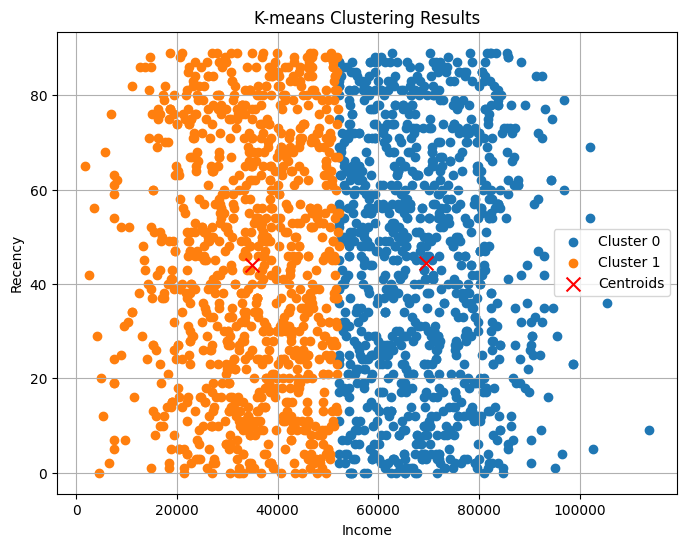

In [109]:
plt.figure(figsize=(8, 6))
for cluster_label in range(k):
    cluster_data = df_operate[df_operate['cluster'] == cluster_label]
    plt.scatter(cluster_data['Income'], cluster_data['Recency'], label=f'Cluster {cluster_label}')

plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=100, c='red', marker='x', label='Centroids')
plt.xlabel('Income')
plt.ylabel('Recency')
plt.title('K-means Clustering Results')
plt.legend()
plt.grid(True)
plt.show()

Investigation into Characteristics of each cluster:


In [110]:
mean_income = df_operate['Income'].mean()
cluster_means = df_operate.groupby('cluster')['Income'].mean()

print("The mean income for the entire dataset is: ")
print(mean_income)

print("The mean income for each cluster is: ")
print(cluster_means)




lower_income = df_operate[df_operate['cluster']== 1]
lower_income_max  = lower_income['Income'].max() 

higher_income = df_operate[df_operate['cluster']== 0]
higher_income_max  = higher_income['Income'].min() 


print("The max income of the lower income category is: ")
print(lower_income_max)
print("The minimum income of the higher income category is: ")
print(higher_income_max)


#can see that the clusters are reasonably separated about the mean.




The mean income for the entire dataset is: 
51638.5404443272
The mean income for each cluster is: 
cluster
0    69056.135871
1    34494.430324
Name: Income, dtype: float64
The max income of the lower income category is: 
52157.0
The minimum income of the higher income category is: 
52190.0
